# Data Preprocessing

In [46]:
#load CompositeEmbeddings.csv into a dataframe
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
df = pd.read_csv('CompositeEmbeddings.csv')

# define a function to convert string to list
def str_to_list(s):
    s = s.strip('[]')
    s_list = s.split()
    return [np.float64(i) for i in s_list]

df['sbert_embedding'] = df['sbert_embedding'].apply(lambda x: ast.literal_eval(x))
df['mpnet_embedding'] = df['mpnet_embedding'].apply(str_to_list)
df.rename(columns={'sbert_embedding':'train_y', 'mpnet_embedding':'train_x'}, inplace=True)

#get train_x and train_y as numpy arrays
unsplit_x = np.array(df['train_x'].tolist())
unsplit_y = np.array(df['train_y'].tolist())

#shuffle the data
from sklearn.utils import shuffle
unsplit_x, unsplit_y = shuffle(unsplit_x, unsplit_y, random_state=42)

# split your data into training and test sets
train_x, test_x, train_y, test_y = train_test_split(unsplit_x, unsplit_y, test_size=0.2, random_state=42)

#x: sbert_embedding (768 dim)
#y: mpnet_embedding (384 dim)

# Neural Net

Epoch 1/50
160/160 [==============================] - 3s 17ms/step - loss: -0.4453 - val_loss: -0.6208
Epoch 2/50
160/160 [==============================] - 3s 16ms/step - loss: -0.5982 - val_loss: -0.6612
Epoch 3/50
160/160 [==============================] - 3s 16ms/step - loss: -0.6350 - val_loss: -0.6801
Epoch 4/50
160/160 [==============================] - 3s 16ms/step - loss: -0.6562 - val_loss: -0.6913
Epoch 5/50
160/160 [==============================] - 3s 16ms/step - loss: -0.6712 - val_loss: -0.6990
Epoch 6/50
160/160 [==============================] - 3s 16ms/step - loss: -0.6831 - val_loss: -0.7052
Epoch 7/50
160/160 [==============================] - 3s 16ms/step - loss: -0.6931 - val_loss: -0.7093
Epoch 8/50
160/160 [==============================] - 3s 16ms/step - loss: -0.7013 - val_loss: -0.7141
Epoch 9/50
160/160 [==============================] - 3s 16ms/step - loss: -0.7089 - val_loss: -0.7177
Epoch 10/50
160/160 [==============================] - 3s 16ms/step - los

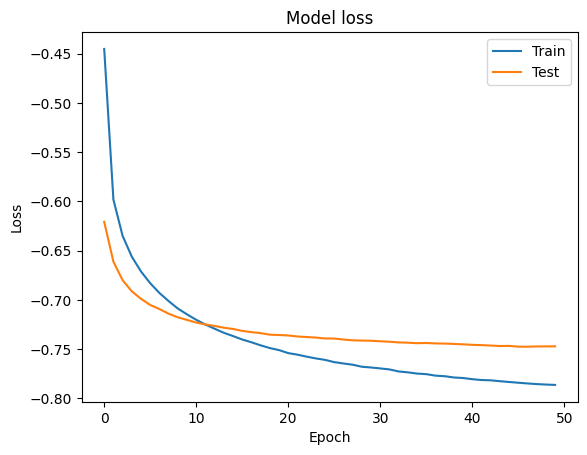

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

# create an instance of the Adam optimizer with a custom learning rate
# opt = Adam(learning_rate=0.001)  # change this to your desired learning rate

def cosine_similarity_loss(y_true, y_pred):
    y_true = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred = tf.nn.l2_normalize(y_pred, axis=-1)
    return -tf.reduce_mean(tf.reduce_sum(y_true * y_pred, axis=-1))

# Initialize the constructor
model = Sequential()


# Add an first hidden layer 
model.add(Dense(2048, activation='relu', input_shape=(768,), kernel_regularizer=l2(0.00)))

# Add a dropout layer for regularization
model.add(Dropout(0.5))

# Add an first hidden layer 
model.add(Dense(2048, activation='relu', kernel_regularizer=l2(0.00)))

# Add a dropout layer for regularization
model.add(Dropout(0.5))


# Add an output layer 
model.add(Dense(384, activation='linear'))

# compile model
model.compile(loss=cosine_similarity_loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))


# add early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# fit the model to the training data
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=50, batch_size=50, callbacks=[es])

# plot the training loss
plt.plot(history.history['loss'])
# plot the validation loss
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

the above runs as n^2, not really worth it

In [73]:
from sentence_transformers import SentenceTransformer
import numpy as np
mpnet_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

encoding_target = ["The talented pianist's fingers danced across the keys, filling the concert hall with a symphony of melodic enchantment. The audience was spellbound, captivated by the musician's virtuosity."]

mpnet_encoded_data = [mpnet_model.encode(x) for x in encoding_target]


sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
sbert_encoded_data = [sbert_model.encode(x) for x in encoding_target]

#input: mpnet encoded.
#output: sbert encoded.

#forward pass (mpnet) -> pseudo-sbert
#cosine similarity between sbert and pseudo sbert

print(len(mpnet_encoded_data[0]))
print(len(sbert_encoded_data[0]))

#convert sbert_encoded_data to numpy array
mpnet_encoded_array = np.array(mpnet_encoded_data[0])
# print(mpnet_encoded_array.shape)

mpnet_reshaped = mpnet_encoded_array.reshape(1, 768)

predictions = model.predict(mpnet_reshaped)

vec1=np.array(sbert_encoded_data[0])
vec2=np.array(predictions[0])

#cosine similarity between sbert and pseudo sbert
similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
print("similarity: ", similarity)

768
384
1/1 [==============================] - 0s 11ms/step
similarity:  0.7397775


In [76]:
#eval data:
evalsentences=["The majestic mountain peak was kissed by the golden rays of the rising sun. The tranquil lake below mirrored the breathtaking beauty above.", "The aroma of freshly brewed coffee filled the air as the barista expertly crafted a latte art masterpiece. Customers eagerly waited to savor the rich flavors and delicate designs.", "The talented pianist's fingers danced across the keys, filling the concert hall with a symphony of melodic enchantment. The audience was spellbound, captivated by the musician's virtuosity.", "The bustling city streets pulsed with life as pedestrians hurriedly navigated through the vibrant crowd. Street vendors enticed passersby with the tantalizing scents of sizzling street food.", "The avid reader eagerly turned the pages of a thrilling mystery novel, engrossed in the intricate plot twists and unexpected revelations. Suspense hung in the air, begging for resolution.", "The diligent gardener tenderly nurtured the delicate blossoms, ensuring they received just the right amount of sunlight and water. The vibrant garden bloomed with a kaleidoscope of colors.", "The football stadium erupted in cheers as the striker's powerful kick sent the ball soaring into the net. Victory was within reach, and the team celebrated their impending triumph.", "The skilled surgeon meticulously performed intricate surgical procedures, guided by years of training and expertise. Each precise movement brought hope and healing to grateful patients.", "The adventurous traveler embarked on a thrilling safari, witnessing the awe-inspiring beauty of majestic wildlife in their natural habitat. The vast savannah stretched out before them, teeming with life.", "The dedicated scientist meticulously analyzed data in the lab, searching for the elusive breakthrough that could revolutionize the field. Hours of research and experimentation were driven by the pursuit of knowledge."]

#for each eval sentence, encode with sbert

eval_sbert_encoded_data = [sbert_model.encode(x) for x in evalsentences]

#for each eval sentence, encode with mpnet
eval_mpnet_encoded_data = [mpnet_model.encode(x) for x in evalsentences]
#translate mpnet to sbert using the trained model
eval_mpnet_encoded_array = np.array(eval_mpnet_encoded_data)
eval_mpnet_reshaped = eval_mpnet_encoded_array.reshape(10, 768)
eval_predictions = model.predict(eval_mpnet_reshaped)
eval_predictions_list = [eval_predictions[i] for i in range(len(eval_predictions))]


# Create a dataframe
df = pd.DataFrame()
df2=pd.DataFrame()
# Add the evaluation sentences and their encoded representations to the dataframe
df['Sentence'] = evalsentences
df['Encoded Data'] = eval_sbert_encoded_data
df['Model'] = "sbert"
#append eval_predictions to the dataframe, with model="translated", and sentence="evalsentences"
df2['Sentence'] = evalsentences
df2['Encoded Data'] = eval_predictions_list
df2['Model'] = "translated"

#append df2 to df
df = df.append(df2)

searchphrase = "I enjoy lots of empirical evidence to support a hypothesis."

#encode searchphrase with sbert
searchphrase_encoded = sbert_model.encode(searchphrase)

#get the top 5 most similar sentences from the dataframe
df['Similarity'] = df['Encoded Data'].apply(lambda x: np.dot(x, searchphrase_encoded) / (np.linalg.norm(x) * np.linalg.norm(searchphrase_encoded)))

df3 = df.sort_values(by=['Similarity'], ascending=False)
print(df3.head(6))




1/1 [==============================] - 0s 12ms/step
                                            Sentence  \
9  The dedicated scientist meticulously analyzed ...   
9  The dedicated scientist meticulously analyzed ...   
4  The avid reader eagerly turned the pages of a ...   
8  The adventurous traveler embarked on a thrilli...   
4  The avid reader eagerly turned the pages of a ...   
1  The aroma of freshly brewed coffee filled the ...   

                                        Encoded Data       Model  Similarity  
9  [0.0064666118, 0.10425878, 0.025711626, 0.0904...       sbert    0.370530  
9  [-1.9748294, -0.13617548, -0.47145933, 0.36107...  translated    0.345943  
4  [-1.0304072, 0.08102151, 0.053058594, 0.682452...  translated    0.158007  
8  [0.8774706, 0.7717499, 0.7904811, 1.6466817, 1...  translated    0.141247  
4  [-0.044758637, -0.02240561, 0.036576904, 0.085...       sbert    0.091916  
1  [-0.02309396, -0.025528274, 0.016727421, 0.089...       sbert    0.089147  


/var/folders/df/br9x1p694yqbc018jsk59t6h0000gn/T/ipykernel_22127/3955033515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2)
